In [42]:
#pip install nibabel

In [1]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
#matching images with their masks
import os

base_dir = 'MRI/'
images_dir = os.path.join(base_dir, 'Anatomical_mag_echo5')
masks_dir = os.path.join(base_dir, 'whole_liver_segmentation')

# List comprehension to get full paths of files
image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii')]
mask_paths = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.nii')]

# Sort to ensure matching order
image_paths.sort()
mask_paths.sort()
# Check the number of images and labels gathered
print(f"Total images: {len(image_paths)}")
print(f"Total labels: {len(mask_paths)}")


Total images: 115
Total labels: 115


In [3]:
# Example check (adapt based on your naming convention)
for img_path, mask_path in zip(image_paths, mask_paths):
    img_id = os.path.basename(img_path).split('.')[0]
    #print('img_id:'+img_id)
    mask_id = os.path.basename(mask_path).split('.')[0]
    #print('mask_id'+mask_id)
    assert img_id == mask_id, f"Image and mask ID do not match! {img_id} vs {mask_id}"


In [3]:
import tensorflow as tf
import random

class NiiDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1))
        y = np.zeros((self.batch_size, *self.image_size, 1))

        for i, (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
            image = nib.load(image_filename)
            mask = nib.load(mask_filename)
            # get the data from the image object
            image_data = image.get_fdata()
            mask_data = mask.get_fdata()
            # get random slice from the volumes
            slice_index = random.randint(0, image_data.shape[2] - 1)
            x[i, :, :, 0] = image_data[:, :, slice_index]
            y[i, :, :, 0] = mask_data[:, :, slice_index]
        
        return x, y


batch_size = 10 # The batch size to use when training the model
image_size = (224, 224)  # The size of the images

In [ ]:
#---------------------------------------

In [19]:
#pip install tensorflow


     |████████████████████████████████| 208.8 MB 239 kB/s eta 0:00:019█████████████▋             | 121.3 MB 8.5 MB/s eta 0:00:11
     |████████████████████████████████| 3.4 MB 64.1 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 38.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 86.0 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 35.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.7 MB 180.7 MB/s eta 0:00:01
     |████████████████████████████████| 441 kB 182.0 MB/s eta 0:00:01
     |████████████████████████████████| 20.6 MB 50.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 39.6 MB/s  eta 0:00:01
     |████████████████████████████████|

In [7]:
import tensorflow as tf
import tifffile as tiff
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Concatenate

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [5]:
# Building the SegNet Model

def encoder_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(input_tensor, skip_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = UpSampling2D(size=(2, 2))(input_tensor)
    x = Concatenate()([x, skip_tensor])
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_segnet_model(input_img, n_filters=64, n_classes=1, dropout=0.1, batchnorm=True):
    # Contracting Path (encoder)
    c1 = encoder_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = encoder_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = encoder_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = encoder_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Expanding Path (decoder)
    u6 = decoder_block(c4, c3, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    u7 = decoder_block(u6, c2, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    u8 = decoder_block(u7, c1, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    # Output layer
    output_img = Conv2D(n_classes, (1, 1), activation='sigmoid')(u8)
    
    return Model(inputs=input_img, outputs=output_img)

In [8]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def calculate_tpr_fpr(y_true, y_pred):
    # Assuming y_pred is sigmoid output, threshold to get binary mask
    y_pred = y_pred > 0.5
    # Flatten the arrays to compute confusion matrix
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_true_f, y_pred_f).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr


In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 30
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)

# ModelCheckpoint
checkpoint_path = "/Users/tongfeiyang/Desktop/liver_project/model_checkpoint.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

In [10]:
from sklearn.model_selection import KFold

# Assuming image_paths and mask_paths are your full datasets
data_size = len(image_paths)
indices = np.arange(data_size)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []



In [11]:
# Assuming 'kf', 'image_paths', 'mask_paths', 'batch_size', 'image_size' are defined
for fold, (train_indices, val_indices) in enumerate(kf.split(indices)):
    print(f"Training on fold {fold+1}/5...")
    
    # Split your data
    train_images_subset = [image_paths[i] for i in train_indices]
    train_masks_subset = [mask_paths[i] for i in train_indices]
    val_images_subset = [image_paths[i] for i in val_indices]
    val_masks_subset = [mask_paths[i] for i in val_indices]
    
    # Data generators
    train_generator = NiiDataGenerator(train_images_subset, train_masks_subset, batch_size, image_size)
    val_generator = NiiDataGenerator(val_images_subset, val_masks_subset, batch_size, image_size)

    # Model setup and training
    input_img = Input((224, 224, 1), name='img')
    model = get_segnet_model(input_img)
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])
    history = model.fit(
        train_generator, 
        validation_data=val_generator, 
        epochs=5, 
        callbacks=[model_checkpoint, early_stopping, lr_scheduler])

    # Predict on the validation set
    val_predictions = []
    val_trues = []
    for i in range(len(val_generator)):
        x, y = val_generator[i]
        preds = model.predict(x)
        val_predictions.extend(preds)
        val_trues.extend(y)
    
    val_predictions = np.array(val_predictions)
    val_trues = np.array(val_trues)

    # Calculate TPR and FPR
    tpr, fpr = calculate_tpr_fpr(val_trues, val_predictions)
    
    # Save fold results
    fold_results.append({
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_dice_coef': history.history['dice_coef'],
        'val_dice_coef': history.history['val_dice_coef'],
        'train_iou_coef': history.history['iou_coef'],
        'val_iou_coef': history.history['val_iou_coef'],
        'tpr': tpr,
        'fpr': fpr
    })


Training on fold 1/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.8196 - dice_coef: 0.1216 - iou_coef: 0.0615 
Epoch 1: val_loss improved from inf to 1701.53979, saving model to /Users/tongfeiyang/Desktop/liver_project/model_checkpoint.h5
10/10 [==============================] - 115s 11s/step - loss: 0.8196 - dice_coef: 0.1216 - iou_coef: 0.0615 - val_loss: 1701.5398 - val_dice_coef: 0.0799 - val_iou_coef: 0.0418 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 0.5925 - dice_coef: 0.1998 - iou_coef: 0.1017 
Epoch 2: val_loss improved from 1701.53979 to 284.25012, saving model to /Users/tongfeiyang/Desktop/liver_project/model_checkpoint.h5
10/10 [==============================] - 119s 12s/step - loss: 0.5925 - dice_coef: 0.1998 - iou_coef: 0.1017 - val_loss: 284.2501 - val_dice_coef: 0.0607 - val_iou_coef: 0.0317 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.5046 - dice_coef: 0.2803 - iou_coef: 0.1330
Epoch 3: val_loss improved from 284.25012 to 10.54226, saving model to /Users/tongfeiyang/Desktop/liver_project/model_checkpoint.h5
10/10 [==============================] - 109s 11s/step - loss: 0.5046 - dice_coef: 0.2803 - iou_coef: 0.1330 - val_loss: 10.5423 - val_dice_coef: 7.4155e-05 - val_iou_coef: 0.3340 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.4706 - dice_coef: 0.3098 - iou_coef: 0.1498
Epoch 5: val_loss did not improve from 4.88920
1/1 [==============================] - 3s 3s/step
Training on fold 5/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.7696 - dice_coef: 0.1521 - iou_coef: 0.0746
Epoch 1: val_loss did not improve from 4.88920
10/10 [==============================] - 100s 10s/step - loss: 0.7696 - dice_coef: 0.1521 - iou_coef: 0.0746 - val_loss: 19.1519 - val_dice_coef: 5.5669e-05 - val_iou_coef: 0.0019 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.5045 - dice_coef: 0.3159 - iou_coef: 0.1653
Epoch 2: val_loss did not improve from 4.88920
10/10 [======

In [13]:
fold_results

[{'train_loss': [0.8195831775665283,
   0.5924811363220215,
   0.5045778155326843,
   0.3965359628200531,
   0.3776077628135681],
  'val_loss': [1701.539794921875,
   284.2501220703125,
   10.542263984680176,
   6.055774211883545,
   33.18405532836914],
  'train_dice_coef': [0.12161172926425934,
   0.19979636371135712,
   0.2803019881248474,
   0.4397422671318054,
   0.432426393032074],
  'val_dice_coef': [0.07991569489240646,
   0.06072547659277916,
   7.41545736673288e-05,
   0.4885421097278595,
   0.043589998036623],
  'train_iou_coef': [0.06145623326301575,
   0.10172130912542343,
   0.13297472894191742,
   0.23670224845409393,
   0.2238343060016632],
  'val_iou_coef': [0.04175436869263649,
   0.031672120094299316,
   0.3340388238430023,
   0.4560212194919586,
   0.022588973864912987],
  'tpr': 0.7615255971844345,
  'fpr': 0.9383251764073172},
 {'train_loss': [0.7856126427650452,
   0.5361244678497314,
   0.5010729432106018,
   0.4243747293949127,
   0.47203734517097473],
  'val_lo

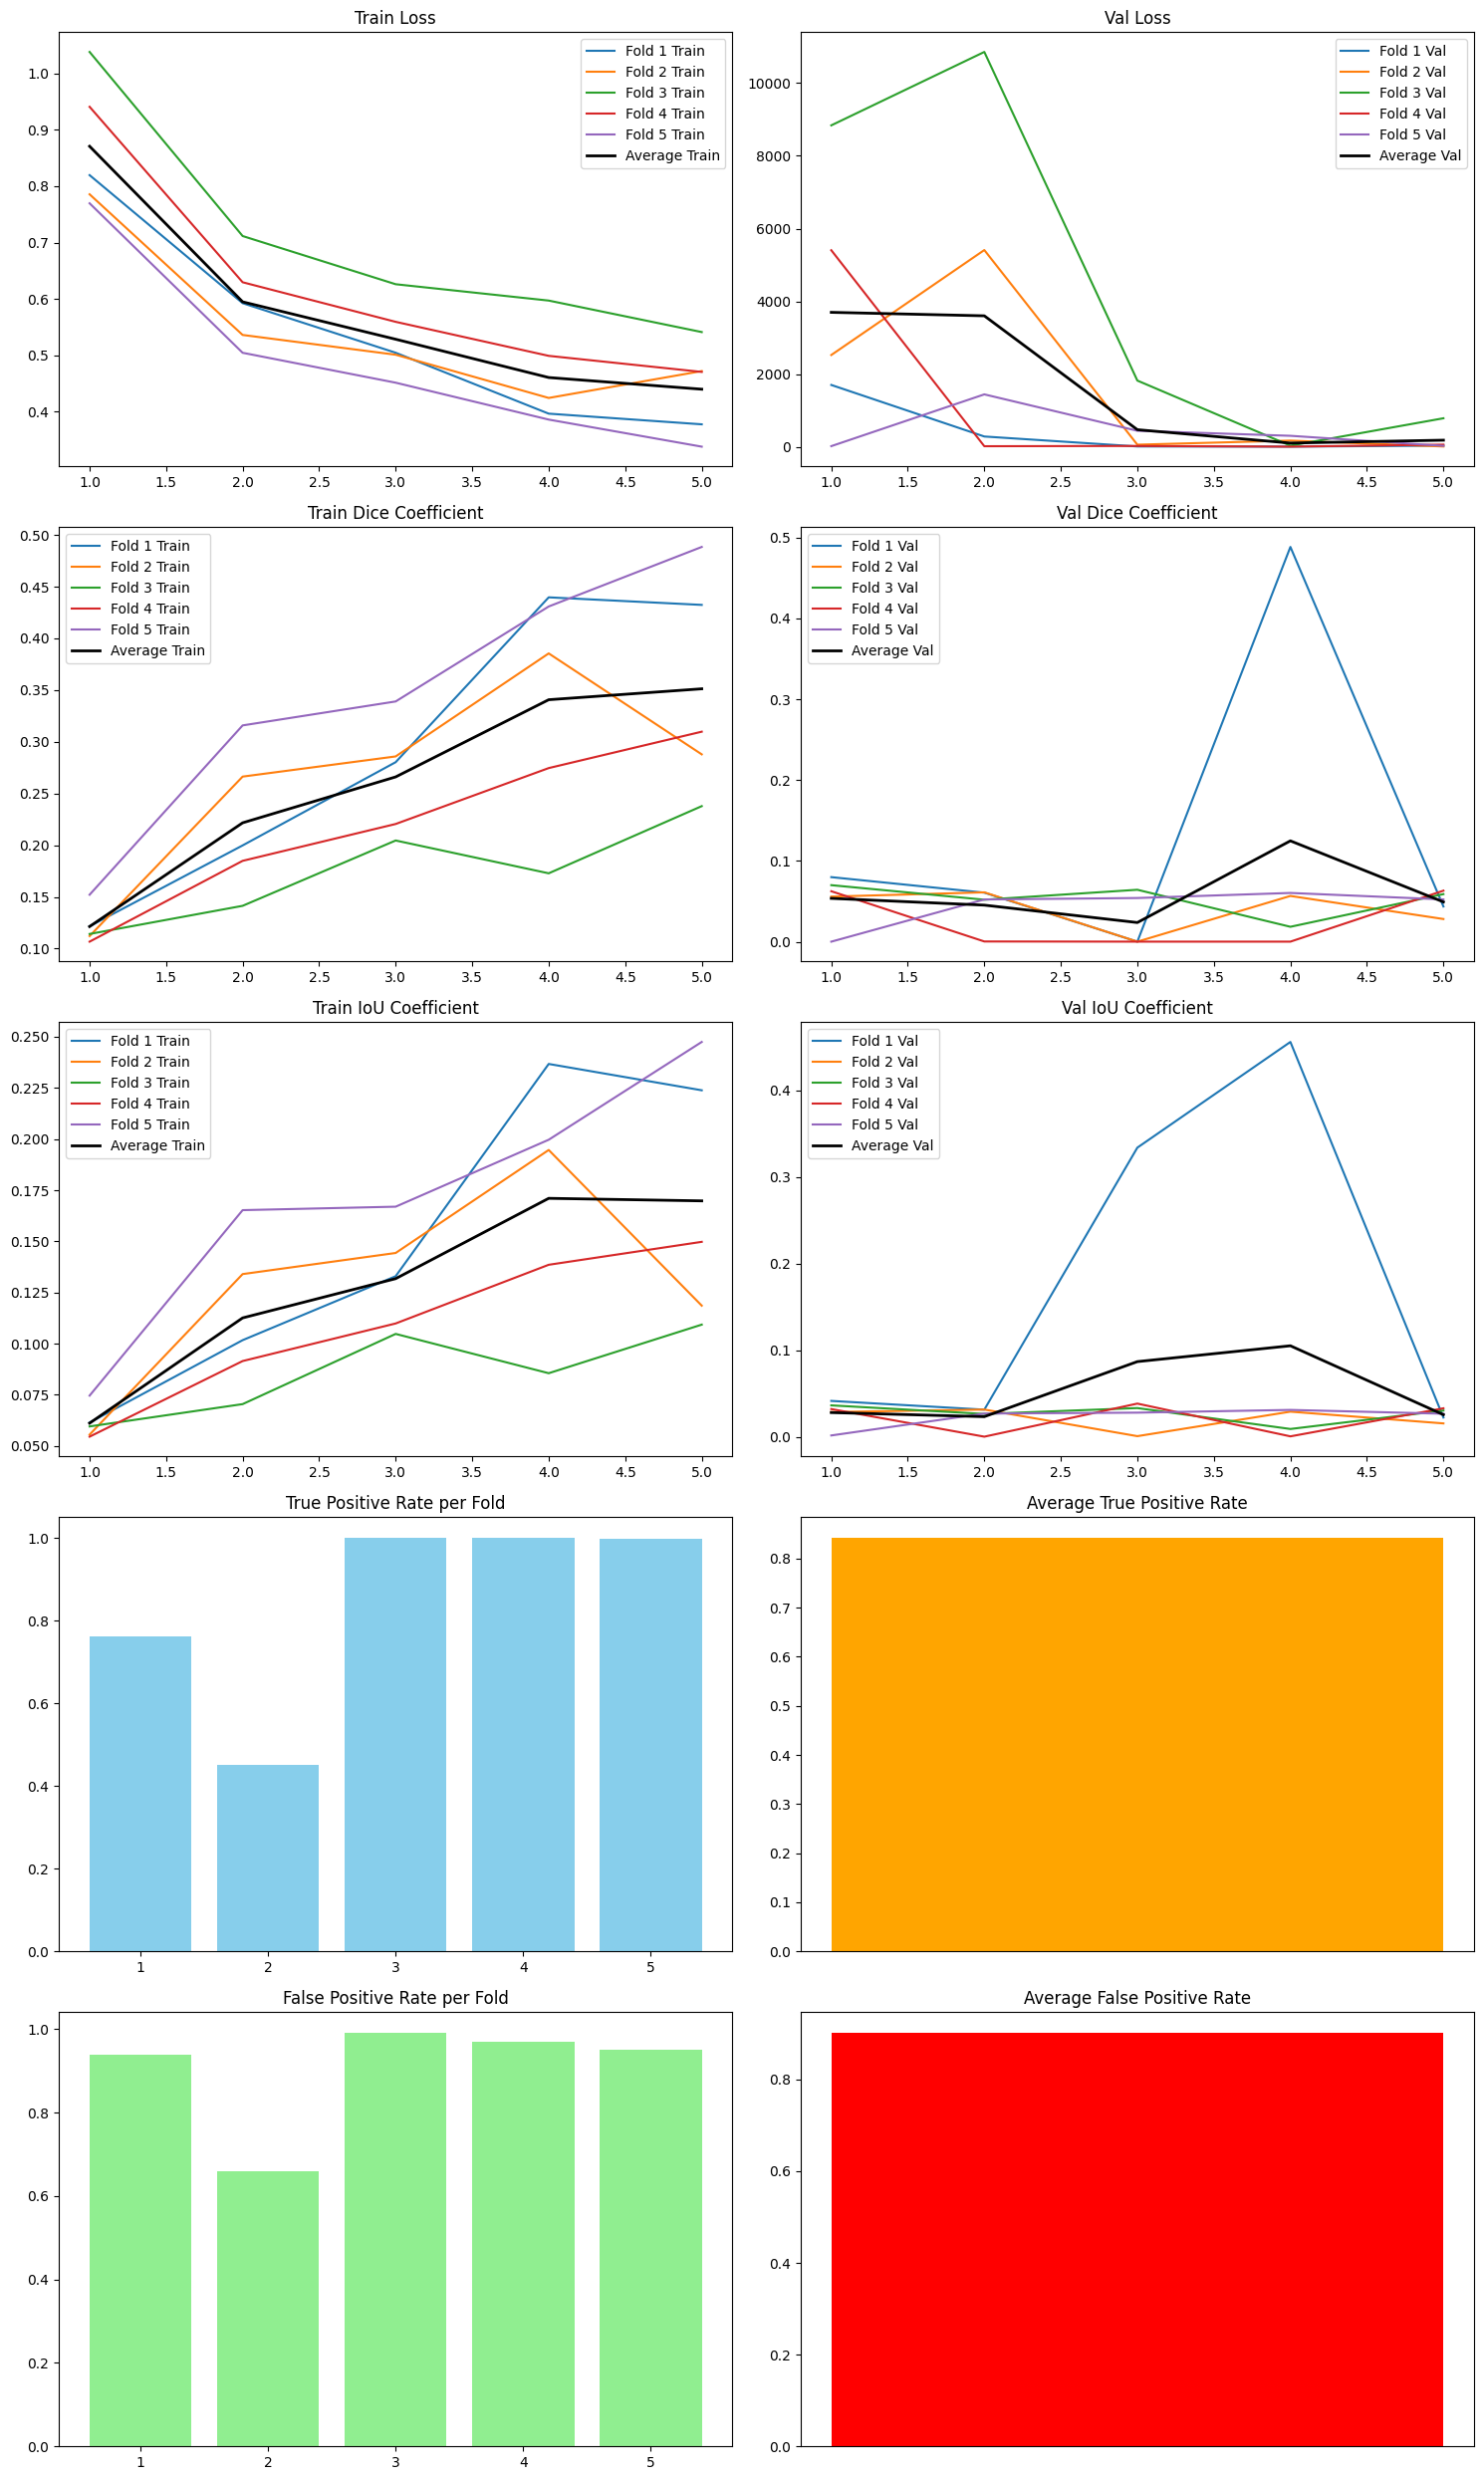

In [14]:
# Recalculating the average metrics across all folds
avg_metrics = {
    'train_loss': np.mean([fold['train_loss'] for fold in fold_results], axis=0),
    'val_loss': np.mean([fold['val_loss'] for fold in fold_results], axis=0),
    'train_dice_coef': np.mean([fold['train_dice_coef'] for fold in fold_results], axis=0),
    'val_dice_coef': np.mean([fold['val_dice_coef'] for fold in fold_results], axis=0),
    'train_iou_coef': np.mean([fold['train_iou_coef'] for fold in fold_results], axis=0),
    'val_iou_coef': np.mean([fold['val_iou_coef'] for fold in fold_results], axis=0),
    'tpr': np.mean([fold['tpr'] for fold in fold_results]),
    'fpr': np.mean([fold['fpr'] for fold in fold_results]),
}

# Plotting metrics for each fold and the averages
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 5 metrics (loss, dice coef, iou coef, tpr, fpr), 2 columns (train, val)
metrics = ['loss', 'dice_coef', 'iou_coef']
titles = ['Loss', 'Dice Coefficient', 'IoU Coefficient', 'True Positive Rate', 'False Positive Rate']
epochs = range(1, 6)

# Plot for each metric
for i, metric in enumerate(metrics):
    for fold_idx, fold in enumerate(fold_results):
        axes[i, 0].plot(epochs, fold[f'train_{metric}'], label=f'Fold {fold_idx+1} Train')
        axes[i, 1].plot(epochs, fold[f'val_{metric}'], label=f'Fold {fold_idx+1} Val')
    # Averages
    axes[i, 0].plot(epochs, avg_metrics[f'train_{metric}'], label='Average Train', linewidth=2, color='black')
    axes[i, 1].plot(epochs, avg_metrics[f'val_{metric}'], label='Average Val', linewidth=2, color='black')
    axes[i, 0].set_title(f'Train {titles[i]}')
    axes[i, 1].set_title(f'Val {titles[i]}')
    axes[i, 0].legend()
    axes[i, 1].legend()

# True Positive Rate and False Positive Rate (only one value, not over epochs)
axes[3, 0].bar(np.arange(1, len(fold_results) + 1), [fold['tpr'] for fold in fold_results], color='skyblue', label='Fold TPR')
axes[3, 0].set_title('True Positive Rate per Fold')
axes[3, 1].bar(np.arange(1), [avg_metrics['tpr']], color='orange', label='Average TPR')
axes[3, 1].set_title('Average True Positive Rate')
axes[3, 0].set_xticks(np.arange(1, len(fold_results) + 1))
axes[3, 1].set_xticks([])

axes[4, 0].bar(np.arange(1, len(fold_results) + 1), [fold['fpr'] for fold in fold_results], color='lightgreen', label='Fold FPR')
axes[4, 0].set_title('False Positive Rate per Fold')
axes[4, 1].bar(np.arange(1), [avg_metrics['fpr']], color='red', label='Average FPR')
axes[4, 1].set_title('Average False Positive Rate')
axes[4, 0].set_xticks(np.arange(1, len(fold_results) + 1))
axes[4, 1].set_xticks([])

fig.tight_layout()
plt.show()


In [ ]:
def calculate_tpr_fpr(y_true, y_pred):
    # Assuming y_pred is sigmoid output, threshold to get binary mask
    y_pred = y_pred > 0.5
    # Flatten the arrays to compute confusion matrix
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_true_f, y_pred_f).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr